### Importation des librairies

In [89]:
import mlflow
import mlflow.sklearn
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow.models.signature import infer_signature
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import joblib
import warnings
#Traitement des messages d'erreur :
warnings.filterwarnings('ignore')
import timeit
#Librairie pour gérer l'espace mémoire du PC
import gc
#Librairie pour créer un dataset de train et un de test
from sklearn.model_selection import train_test_split
#Librairie pour l'encodage des variables catégorielles
from sklearn.preprocessing import LabelEncoder
#Librairies pour réaliser un pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
# Importation du package pour le SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
import math
#Librairie pour XGBoostClassifier
from xgboost import XGBClassifier
#Librairie pour les métriques avec GridSearch
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
#Librairie pour l'optimisation des hyperparamètres et calcul d'un score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
#Librairies pour les approches globale et locale
import shap
import lime
from lime import lime_tabular
import random
#Librairies pour le data drift
import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset
from evidently.test_preset import DataQualityTestPreset
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

### Fonction utilisées dans le notebook

In [53]:
#Pipeline pour transformer les variables numériques à l'aide d'un SimpleImputer, d'un RobustScaler et d'un ColumnTransformer
def Preprocessing (numeric):
    """Pipeline pour réaliser un SimpleImputer, un RobustScaler et un ColumnTransformer sur les variables numériques"""
    #On prend la médiane pour les valeurs manquantes, et on traite les outliers grâce au RobustScaler.
    #Le ColumnTransformer nous permet de réaliser toutes ces opérations en une seule fois
    numeric_transfs = [('imputer',SimpleImputer(missing_values= np.NAN, strategy= 'median')),('scaler', RobustScaler())]
    numeric_pipeline = Pipeline(numeric_transfs)
    all_transfs = [("numeric",numeric_pipeline,numeric)]
    full_preprocessor = ColumnTransformer(all_transfs, remainder='passthrough')
    return full_preprocessor

In [54]:
#Fonction pour calculer le score afin de pouvoir faire une comparaison avec la fonction coût métier
def find_score(y_true, y_pred, poids):
    """Fonction pour calculer le score afin de pouvoir faire une comparaison avec la fonction coût métier"""
    #Matrice de confusion
    true_pos, true_neg, false_pos, false_neg = confusion_matrix(y_true, y_pred).ravel()
    Score = poids*false_neg+false_pos
    return Score

#Fonction pour trouver les meilleurs hyper paramètres
def find_params(parameters):
    """Fonction pour trouver les meilleurs hyper paramètres"""
    #1 représente le poids dans le calcul du score
    poids=1
    model = XGBClassifier(model__max_depth = parameters['model__max_depth'], 
                          model__learning_rate = parameters['model__learning_rate'],
                          model__n_estimators = parameters['model__n_estimators'], 
                          model__subsample = parameters['model__subsample'],
                          model__colsample_bytree = parameters['model__colsample_bytree'],  
                         )

    y_pred = cross_val_predict(model, X_train_smote, y_train_smote, method='predict', cv=5)
    Score = find_score(y_train_smote, y_pred, poids)

    # Nous visons à maximiser la précision, nous la renvoyons donc comme une valeur négative
    return {'loss': -Score, 'status': STATUS_OK }

#Fonction pour affiche la matrice de confusion et la courbe AUC
def aff_conf_mat_auc_param(y_true, y_pred, y_pred_proba):
    """Fonction pour calculer et afficher une matrice de conusionet l'AUC"""
    class_report = classification_report(y_test, xgb_model.predict(X_test_transformed))
    print(class_report)
    conf_mat = confusion_matrix(y_true, y_pred)#.ravel
    fig = plt.figure(figsize=(10,10))
    group_names = ['Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs', 'Vrais Positifs']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues')
    
    fig = plt.figure(figsize=(10,10))
    false_positive, true_positive, _ = roc_curve(y_true, y_pred_proba)
    model_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(false_positive, true_positive, label = "AUC = %0.2f" %model_roc_auc_score)
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.xlabel("Taux de Faux Positifs")
    plt.ylabel("Taux de Vrais Positifs")
    plt.title("Courbe de l'AUC")
    plt.legend(loc = 'upper left')
    plt.show()

In [55]:
#Fonction coût métier
def cout_metier(y_true, y_pred, poids):
    """Fonction coût métier afin de donner un poids plus important aux faux négatifs"""
    #Matrice de confusion
    true_pos, true_neg, false_pos, false_neg = confusion_matrix(y_true, y_pred).ravel()
    Score = poids*false_neg+false_pos
    return Score

#Fonction pour trouver les meilleurs hyperparamètres en utilisant Hyperopt
def improve_params(parameters_hyper):
    """Fonction pour trouvr les meilleurs hyperparamètres en utilisant Hyperopt"""
    #10 représente le poids dans le calcul du score
    poids=10
    model = XGBClassifier(model__max_depth = parameters_hyper['model__max_depth'], 
                          model__learning_rate = parameters_hyper['model__learning_rate'],
                          model__n_estimators = parameters_hyper['model__n_estimators'], 
                          model__subsample = parameters_hyper['model__subsample'],
                          model__colsample_bytree = parameters_hyper['model__colsample_bytree'], 
                          #model__random_state = parameters_hyper['model__random_state'], 
                         )

    #accuracy = cross_val_score(model, X_train_smote, y_train_smote, cv = 5).mean()
    y_pred = cross_val_predict(model, X_train_smote, y_train_smote, method='predict', cv=5)
    Score = cout_metier(y_train_smote, y_pred, poids)

    # Nous visons à maximiser la précision, nous la renvoyons donc comme une valeur négative
    return {'loss': -Score, 'status': STATUS_OK }

#Fonction pour affiche la matrice de confusion et la courbe AUC
def aff_conf_mat_auc_improve_param(y_true, y_pred, y_pred_proba):
    """Fonction pour calculer et afficher une matrice de conusionet l'AUC"""
    class_report = classification_report(y_test, xgb_improved.predict(X_test_transformed))
    print(class_report)
    conf_mat = confusion_matrix(y_true, y_pred)#.ravel
    fig = plt.figure(figsize=(10,10))
    group_names = ['Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs', 'Vrais Positifs']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues')
    
    fig = plt.figure(figsize=(10,10))
    false_positive, true_positive, _ = roc_curve(y_true, y_pred_proba)
    model_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(false_positive, true_positive, label = "AUC = %0.2f" %model_roc_auc_score)
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.xlabel("Taux de Faux Positifs")
    plt.ylabel("Taux de Vrais Positifs")
    plt.title("Courbe de l'AUC")
    plt.legend(loc = 'upper left')
    plt.show()

### Lecture des datasets

In [66]:
path = 'Projet_7/'

data_work = pd.read_csv(path + "data_work.csv")
data_target = pd.read_csv(path + "data_target.csv")

In [57]:
display(data_work.head())
data_test = data_work.head()

,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
0,Prêts de trésorerie,M,26,3 à 4,célibataire,0,1,202500,2,1,406597,9251,874,0,20
1,Prêts de trésorerie,F,46,5 à 8,marié(e),0,2,270000,1,0,1293502,56553,1400,0,7
2,Prêts renouvelables,M,52,3 à 4,célibataire,0,1,67500,2,0,135000,5357,867,0,3
3,Prêts de trésorerie,F,52,3 à 4,marié(e),0,2,135000,2,1,312682,23651,1050,0,19
4,Prêts de trésorerie,M,55,3 à 4,célibataire,0,1,121500,2,0,513000,12278,1149,0,6


In [58]:
display(data_target.head(40))
data_test = data_target.head()

,TARGET
0,1
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


### Séparation des données

In [59]:
#On commence par diviser le dataset en un dataset de train et un dataset de test avec une proportion de 80% / 20%
X_train, X_test, y_train, y_test = train_test_split(data_work, data_target, test_size = 0.2)
del data_target

In [60]:
X_train.shape, X_test.shape

((246008, 15), (61503, 15))

### Pré-traitement des données

In [61]:
#On remet la variable concernant une période sous un format positif
X_test['Delai_anticipation_pret'] = X_test['Delai_anticipation_pret'].mul(-1)
#On remet la variable concernant une période sous un format positif
X_train['Delai_anticipation_pret'] = X_train['Delai_anticipation_pret'].mul(-1)

#Création d'une variable avec la liste des colonnes catégorielles du dataset features
data_categ = list(data_work.select_dtypes(exclude=["number"]).columns)
#Création d'une variable avec la liste des colonnes numériques du dataset features
data_num = list(data_work.select_dtypes(exclude=["bool_","object_"]).columns)
print("Voici la liste des colonnes catégorielles : \n", data_categ)
print("Voici la liste des colonnes numériques : \n", data_num)
del data_work
#Permet d'initialiser la librairie gc
gc.enable()
#Permet de supprimer les objets qui ne sont plus utilisés
gc.collect()

Voici la liste des colonnes catégorielles : 
 ['Type_de_pret', 'Genre', 'Niveau_d_etudes', 'Regime_matrimonial']
Voici la liste des colonnes numériques : 
 ['Age', 'Nb_enfants', 'Nb_membre_famille', 'Montant_des_revenus', 'Note_region_client', 'Nb_demande_client', 'Montants_du_pret', 'Montant_des_annuites', 'Nb_jours_credits', 'Montant_anticipation_pret', 'Delai_anticipation_pret']


9288

In [62]:
#On va maintenant encoder les variables catégorielles grâce ai LabelEncoder
encoder = LabelEncoder()

for col in data_categ:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.fit_transform(X_test[col])
display(X_train)

,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
22375,0,0,55,0,2,0,2,315000,2,2,1125171,12006,1367,14069,-8
250875,0,1,44,0,2,1,3,180000,2,3,251280,10909,1288,-10115,-12
213160,0,0,34,1,2,1,3,112500,2,4,545040,14503,909,0,-16
54118,1,0,27,1,2,1,3,180000,3,5,180000,15421,374,0,-9
245465,0,1,28,0,1,0,1,90000,2,1,343800,10477,40,0,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51281,0,1,58,0,2,1,3,400500,3,4,1096020,35554,1049,9373,-10
10527,0,0,32,0,2,1,3,90000,2,0,640080,3589,918,0,-8
300787,0,1,35,0,2,2,4,103500,2,2,675000,9692,676,-2071,-7
273501,0,1,26,0,1,0,1,180000,2,2,497520,11437,593,0,-20


In [63]:
X_train.loc[X_train.index[1]]

Type_de_pret                      0
Genre                             1
Age                              44
Niveau_d_etudes                   0
Regime_matrimonial                2
Nb_enfants                        1
Nb_membre_famille                 3
Montant_des_revenus          180000
Note_region_client                2
Nb_demande_client                 3
Montants_du_pret             251280
Montant_des_annuites          10909
Nb_jours_credits               1288
Montant_anticipation_pret    -10115
Delai_anticipation_pret         -12
Name: 250875, dtype: int64

### Pipelines

In [17]:
preprocessor_fitted = Preprocessing(data_num).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

In [18]:
print("Taille de X_train après avoir utiliser la fonction contenant les Pipelines : ", X_train_transformed.shape)
print("Taille de X_test après avoir utiliser la fonction contenant les Pipelines : ", X_test_transformed.shape)
#On voit que nous n'avons pas de différence ce qui indique que toutes les variables ont bien été traitées.

Taille de X_train après avoir utiliser la fonction contenant les Pipelines :  (246008, 15)
Taille de X_test après avoir utiliser la fonction contenant les Pipelines :  (61503, 15)


### SMOTE

In [19]:
#Nombre d'observations avant le SMOTE
sum_target_1 = (np.sum(y_train==1)).values
sum_target_0 = (np.sum(y_train==0)).values

print("Nous avons ", sum_target_1, " observations pour la classe à 1.")
print("Nous avons ", sum_target_0, " observations pour la classe à 0.")

Nous avons  [19884]  observations pour la classe à 1.
Nous avons  [226124]  observations pour la classe à 0.


In [20]:
#Utilisation du SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_transformed, y_train)

In [21]:
#Nombre d'observations après le SMOTE
sum_target_res_1 = (np.sum(y_train_smote==1)).values
sum_target_res_0 = (np.sum(y_train_smote==0)).values

print("Nous avons ", sum_target_res_1, " observations pour la classe à 1.")
print("Nous avons ", sum_target_res_0, " observations pour la classe à 0.")

Nous avons  [226124]  observations pour la classe à 1.
Nous avons  [226124]  observations pour la classe à 0.


### Recherche des hyperparamètres

In [31]:
xgb = XGBClassifier()

In [106]:
#Création d'une liste pour trouver les meilleurs hyper paramètres en utilisant Hyperopt
parameters = {'model__max_depth': hp.quniform('model__max_depth', 4, 5, 1),
              'model__learning_rate': hp.quniform('model__learning_rate', 0.001, 0.20, 0.001),
              'model__n_estimators': hp.quniform('model__n_estimators', 100, 1000, 100),
              "model__subsample": hp.quniform("model__subsample", 0.9, 1, 0.1),
              "model__colsample_bytree": hp.quniform("model__colsample_bytree", 0.5, 0.6, 0.1),
              #"model__random_state": hp.quniform("model__random_state", 42, 42, 0)
}

In [110]:
best = fmin(fn= find_params,
            space= parameters,
            algo= tpe.suggest,
            max_evals= 5,
            trials= Trials()
           )
best

[22:54:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[22:54:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[22:55:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[22:55:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba262

{'model__colsample_bytree': 0.6000000000000001,
 'model__learning_rate': 0.08600000000000001,
 'model__max_depth': 5.0,
 'model__n_estimators': 600.0,
 'model__subsample': 0.9}

In [111]:
print("Les meilleurs hyper paramètres sont : ", best)

Les meilleurs hyper paramètres sont :  {'model__colsample_bytree': 0.6000000000000001, 'model__learning_rate': 0.08600000000000001, 'model__max_depth': 5.0, 'model__n_estimators': 600.0, 'model__subsample': 0.9}


In [112]:
#Réentrainement du modèle avec les meilleurs hyper paramètres trouvés
xgb_model = XGBClassifier(max_depth=5, learning_rate=0.086, n_estimators=600, subsample=0.9,
                          colsample_bytree=0.6, random_state=42)
xgb_model.fit(X=X_train_smote, y=y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.086, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56517
           1       0.21      0.00      0.01      4986

    accuracy                           0.92     61503
   macro avg       0.56      0.50      0.48     61503
weighted avg       0.86      0.92      0.88     61503



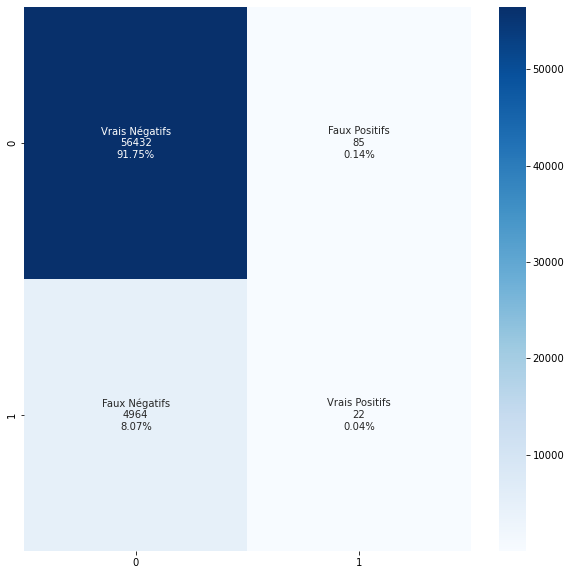

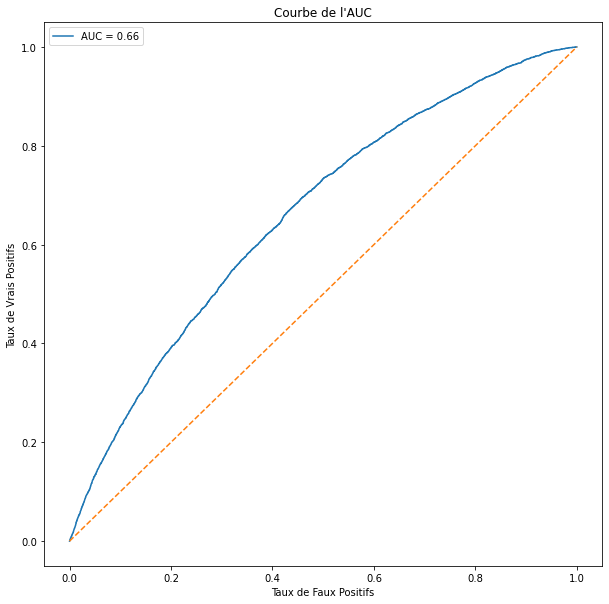

In [115]:
#Affichage de la matrice de confusion et de la courbe AUC
aff_conf_mat_auc_param(y_test, xgb_model.predict(X_test_transformed),
                               xgb_model.predict_proba(X_test_transformed)[:,1])

### Fonction coût métier

Afin de prendre en compte une importance plus importante des observations fausses négétives par rapport aux observations fausses positives, nous allons mettre en place un score en mettant un poids plus important sur les feux négatifs.
On aura donc le Score = poids * faux négatifs + faux positifs
Le but étant de réduire le score pour faire baisser les faux négatifs.
On prendra un poids de 10.
En effet, le risque dans les faux négatifs est une perte pour la banque alors que pour les faux positifs, il s'agit d'un manque à gagner (un prêt non accordé à tort).

In [71]:
#Création d'une liste pour trouver les meilleurs hyper paramètres en utilisant Hyperopt
parameters_hyper = {'model__max_depth': hp.quniform('model__max_depth', 4, 5, 1),
                    'model__learning_rate': hp.quniform('model__learning_rate', 0.001, 0.20, 0.001),
                    'model__n_estimators': hp.quniform('model__n_estimators', 100, 1000, 100),
                    "model__subsample": hp.quniform("model__subsample", 0.9, 1, 0.1),
                    "model__colsample_bytree": hp.quniform("model__colsample_bytree", 0.5, 0.6, 0.1),
                    #"model__random_state": hp.quniform("model__random_state", 42, 42, 0)
}

In [117]:
best = fmin(fn= improve_params,
            space= parameters_hyper,
            algo= tpe.suggest,
            max_evals= 5,
            trials= Trials()
           )
best

[23:15:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[23:16:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[23:16:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[23:17:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba262

{'model__colsample_bytree': 0.6000000000000001,
 'model__learning_rate': 0.14100000000000001,
 'model__max_depth': 5.0,
 'model__n_estimators': 800.0,
 'model__subsample': 0.9}

In [118]:
print("Les meilleurs hyper paramètres avec hyperopt sont : ", best)

Les meilleurs hyper paramètres avec hyperopt sont :  {'model__colsample_bytree': 0.6000000000000001, 'model__learning_rate': 0.14100000000000001, 'model__max_depth': 5.0, 'model__n_estimators': 800.0, 'model__subsample': 0.9}


In [91]:
#Réentrainement du modèle avec les meilleurs hyper paramètres vus avec hyperopt
xgb_improved = XGBClassifier(max_depth=5, learning_rate=0.141, n_estimators=800, subsample=0.9,
                            colsample_bytree=0.6, random_state=42)
xgb_improved.fit(X=X_train_smote, y=y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.141, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56517
           1       0.22      0.00      0.01      4986

    accuracy                           0.92     61503
   macro avg       0.57      0.50      0.48     61503
weighted avg       0.86      0.92      0.88     61503



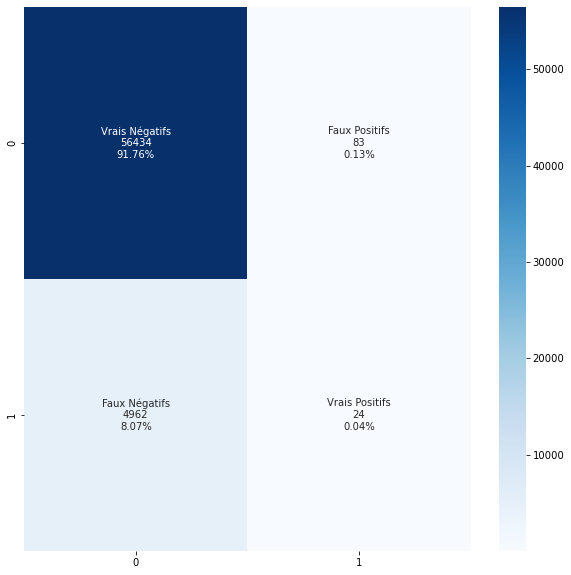

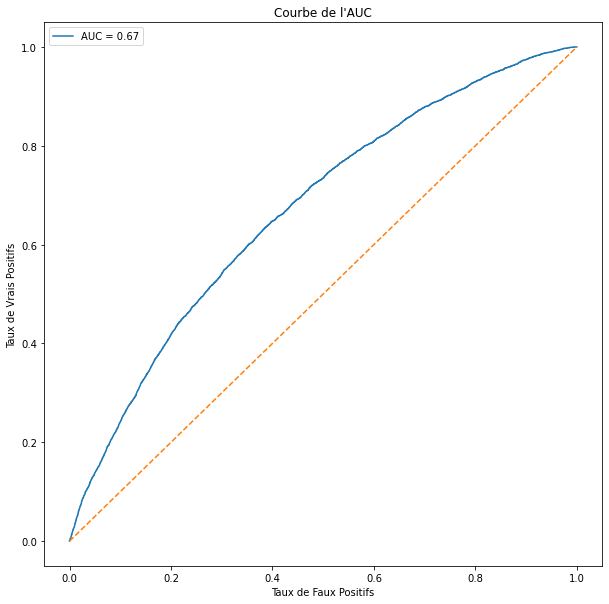

In [120]:
#Affichage de la matrice de confusion et de la courbe AUC
aff_conf_mat_auc_improve_param(y_test, xgb_improved.predict(X_test_transformed),
                               xgb_improved.predict_proba(X_test_transformed)[:,1])

Résultats avant la fonction coût métier :
- Score AUC : 0.66
- Score accuracy : 0.92
- Faux positifs : 0.14 % (85 observations)
- Faux négatifs : 8.07 % (4964 observations)

Résultats après la fonction coût métier :
- Score AUC : 0.67
- Score accuracy : 0.92
- Faux positifs : 0.13 % (83 observations)
- Faux négatifs : 8.07 % 4962 observations)

Avec l'uilisation de la fonction coput métier, on peut voir une légère amélioration du nombre de faux positifs (-2) ainsi que le nombre de faux négatifs (-2). Le score AUC est aussi légèrement amélioré (+1).
De plus nous avons réussi à minimiser le score calculé en passant de -226 169 à -2 069 900.

### Interprétabilité globale du modèle

Nous allons commencer par faire une approche globale afin de voir l'importance des variables du modèle d'un point de vue maccro.
Nous utiliserons la méthode SHAP dans nos différentes interprétabilité (SHapley Additive exPlanations).
Cette méthode nous permettra donc d'expliquer le modèle.

In [100]:
explainer = shap.Explainer(xgb_improved, X_train_smote)
#Calcul de la valeur SHAP de X_train_smote
shap_values = explainer(X_train_smote)

100%|===================| 452211/452248 [135:22<00:00]        

In [101]:
#Conversion du tableau Numpy en Dataframe pour appliquer la méthode SHAP
data_X_train_smote = pd.DataFrame(X_train_smote, columns=data_work.columns)
data_X_test_transformed = pd.DataFrame(X_test_transformed, columns=data_work.columns)

In [102]:
#Calcul de la valeur SHAP de data_X_train_smote
explainer = shap.Explainer(xgb_improved, data_X_train_smote)

In [103]:
shap_values = explainer(data_X_test_transformed)

100%|===================| 61451/61503 [17:54<00:00]        

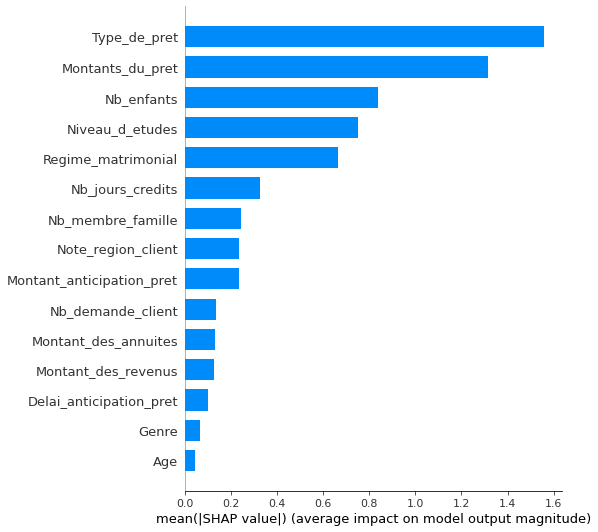

In [104]:
#Affichage du graphique d'interprétabilité globale
shap.summary_plot(shap_values, data_X_test_transformed, plot_type="bar")


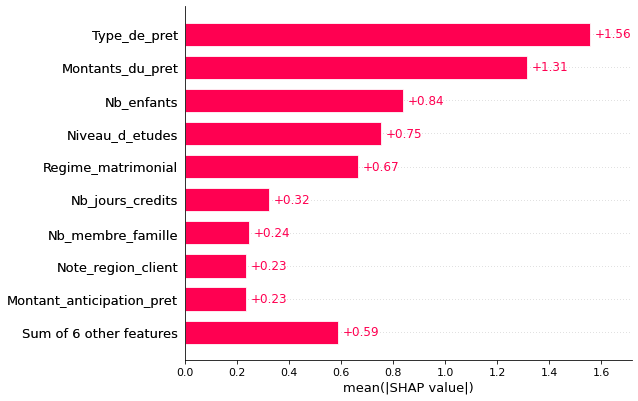

In [105]:
shap.plots.bar(shap_values)

On peut voir que les 3 variables qui sont importantes dans le résultat d'une prédiction sont le type de prêt, son montant et le nombre d'enfants du client.

In [106]:
x= xgb_improved.predict(X_test_transformed)

In [107]:
# extraire les indices des clients dont leur prêt est refusé
x_refus = [i for i in range(len(x)) if x[i] == 1]
x_refus

[319,
 597,
 647,
 1133,
 1158,
 1688,
 2185,
 2752,
 2942,
 3064,
 3200,
 3416,
 3505,
 3676,
 4266,
 4279,
 4475,
 4552,
 4703,
 4911,
 5142,
 5378,
 5402,
 5874,
 5890,
 5989,
 6042,
 6266,
 6277,
 6553,
 6949,
 7353,
 8329,
 8911,
 9101,
 9930,
 10579,
 10628,
 11168,
 11292,
 11766,
 12527,
 12694,
 13498,
 13702,
 13738,
 13849,
 14511,
 16187,
 16341,
 16415,
 16521,
 16841,
 21290,
 21341,
 22323,
 22930,
 23113,
 23344,
 23604,
 23822,
 24406,
 24782,
 25021,
 25273,
 25672,
 26002,
 26455,
 28322,
 28526,
 29826,
 30248,
 31620,
 31717,
 31979,
 33419,
 33527,
 33539,
 33577,
 33723,
 34006,
 34458,
 35114,
 35837,
 37695,
 38767,
 38965,
 39337,
 39837,
 40434,
 41131,
 41302,
 42347,
 42361,
 42590,
 43420,
 43651,
 44348,
 44475,
 44890,
 46289,
 46358,
 46380,
 47257,
 48319,
 48651,
 48671,
 48882,
 49548,
 50170,
 51268,
 51443,
 52070,
 52425,
 52538,
 53378,
 54523,
 54790,
 55416,
 55629,
 57116,
 57740,
 57937,
 58630,
 59122,
 59317,
 59743,
 60981]

In [109]:
# choisir client d'indice = 389 pour un exemple de prêt refusé
xgb_improved.predict(X_test_transformed)[319]

1

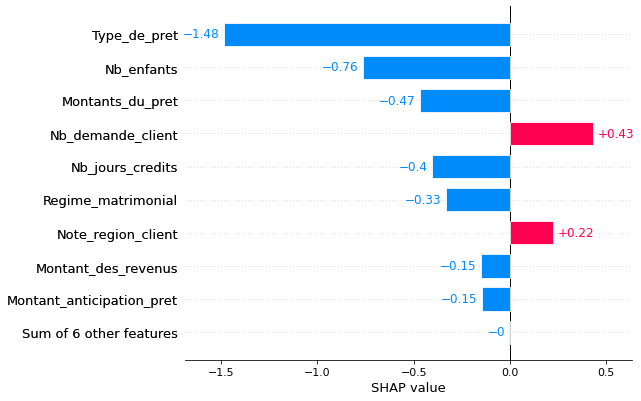

In [111]:
shap.plots.bar(shap_values[319])

In [112]:
#Nous réiterons l'opération pour une personne dont le prêt est accepté
xgb_improved.predict(X_test_transformed)[0]

0

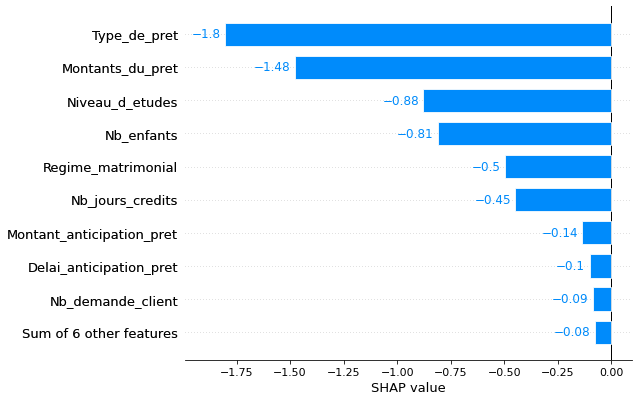

In [113]:
shap.plots.bar(shap_values[0])

In [114]:
display(data_work.head())

,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
0,Prêts de trésorerie,M,26,3 à 4,célibataire,0,1,202500,2,1,406597,9251,874,0,20
1,Prêts de trésorerie,F,46,5 à 8,marié(e),0,2,270000,1,0,1293502,56553,1400,0,7
2,Prêts renouvelables,M,52,3 à 4,célibataire,0,1,67500,2,0,135000,5357,867,0,3
3,Prêts de trésorerie,F,52,3 à 4,marié(e),0,2,135000,2,1,312682,23651,1050,0,19
4,Prêts de trésorerie,M,55,3 à 4,célibataire,0,1,121500,2,0,513000,12278,1149,0,6


### Interprétabilité locale du modèle

### Pipeline de prédiction

In [115]:
scaler = preprocessing.RobustScaler()
#Construction du Pipeline de prédiction comprenant le RobustScaler et le modèle XGBoostClassifier
pipeline = pipeline.Pipeline([('scaler', preprocessing.RobustScaler()),
                              ('xgb', xgb_improved)])

In [116]:
#Lancement de l'apprentissage du pipeline sur les données de train
pipeline.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('scaler', RobustScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.141,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=800, n_jobs=0, num_parallel_tree=1,
                             

In [117]:
#Calcule du coefficient de détermination sur les données de test
pipeline.score(X_test_transformed, y_test)

0.9145570134790173

In [118]:
#Enfin on sérialise le pipeline à l'aide de la librairie joblib
joblib.dump(pipeline, 'pipeline_scoring.joblib')

['pipeline_scoring.joblib']

### Déploiement du modèle avec MLflow

In [119]:
#Utilisation de la fonction infer_signature afin d'extraire la signature à partir des données d'entrée et de sortie
with mlflow.start_run():
        signature = infer_signature(X_train_smote, y_train_smote)

In [120]:
#Sauvegarde du pipeline à l'aide de save_model tout en précisant la signature
mlflow.sklearn.save_model(pipeline, 'xgb_model_final_V3', signature=signature)

### Data Drift

Nous allons étudier à l'aide de la librairie Evidently le Data Drift entre le dataset de train et celui de test

In [76]:
data_drift_work = data_work.copy()
display(data_drift_work.head())
print(data_drift_work.shape)
#On fera un découpage 80/20 du dataset soit 246008 lignes pour data_reference et 61503 lignes pour data_current
data_drift_reference = data_drift_work.iloc[:246008]
data_drift_current = data_drift_work.iloc[246008:]
display(data_drift_reference.head())
print(data_drift_reference.shape)
display(data_drift_current.head())
print(data_drift_current.shape)

,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
0,Prêts de trésorerie,M,26,3 à 4,célibataire,0,1,202500,2,1,406597,9251,874,0,20
1,Prêts de trésorerie,F,46,5 à 8,marié(e),0,2,270000,1,0,1293502,56553,1400,0,7
2,Prêts renouvelables,M,52,3 à 4,célibataire,0,1,67500,2,0,135000,5357,867,0,3
3,Prêts de trésorerie,F,52,3 à 4,marié(e),0,2,135000,2,1,312682,23651,1050,0,19
4,Prêts de trésorerie,M,55,3 à 4,célibataire,0,1,121500,2,0,513000,12278,1149,0,6


(307511, 15)


,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
0,Prêts de trésorerie,M,26,3 à 4,célibataire,0,1,202500,2,1,406597,9251,874,0,20
1,Prêts de trésorerie,F,46,5 à 8,marié(e),0,2,270000,1,0,1293502,56553,1400,0,7
2,Prêts renouvelables,M,52,3 à 4,célibataire,0,1,67500,2,0,135000,5357,867,0,3
3,Prêts de trésorerie,F,52,3 à 4,marié(e),0,2,135000,2,1,312682,23651,1050,0,19
4,Prêts de trésorerie,M,55,3 à 4,célibataire,0,1,121500,2,0,513000,12278,1149,0,6


(246008, 15)


,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
246008,Prêts de trésorerie,F,41,3 à 4,marié(e),1,3,180000,2,1,545040,35734,1050,32921,13
246009,Prêts de trésorerie,F,37,5 à 8,célibataire,1,2,337500,2,1,790830,10789,1050,0,14
246010,Prêts de trésorerie,F,45,3 à 4,célibataire,1,2,63000,2,1,310500,11984,643,0,9
246011,Prêts de trésorerie,F,46,3 à 4,marié(e),0,2,112500,1,0,942300,4511,1443,0,9
246012,Prêts de trésorerie,F,29,3 à 4,marié(e),0,2,180000,2,0,272520,22626,774,-8166,7


(61503, 15)


In [79]:
#Générer le rapport Data Drift
data_drift_report = Report(metrics=[DataDriftPreset(),])

data_drift_report.run(current_data=data_drift_current, reference_data=data_drift_reference, column_mapping=None)
data_drift_report

In [82]:
#Enregistrement du rapport en html
data_drift_report.save_html(path + "reports_data_drift.html")

In [84]:
#Exécuter la suite de tests de stabilité des données et afficher les rapports dans le bloc-notes
data_stability_current_work = data_drift_current.drop(columns="Note_region_client")
data_stability_reference_work = data_drift_reference.drop(columns="Note_region_client")
data_stability= TestSuite(tests=[DataStabilityTestPreset(),])
data_stability.run(current_data=data_stability_current_work, reference_data=data_stability_reference_work, column_mapping=None)
data_stability 

In [85]:
#Enregistrement des résultats dans un fichier html
data_stability.save_html(path + "testing_data_drift.html")

In [ ]:
#Réalisation du dashboard du data drift
data_drift_dashboard = Dashboard(tabs=[DataDriftTab])
data_drift_dashboard.calculate(data_drift_reference, data_drift_current)